# Credit Card Fraud Detection

## Load Dataset
source: https://www.kaggle.com/datasets/whenamancodes/fraud-detection

In [1]:
import pandas as pd

In [2]:
raw_df = pd.read_csv('/kaggle/input/fraud-detection/creditcard.csv')
# raw_df.head()

# raw_df = pd.read_csv('./creditcard.csv')
raw_df.shape

(284807, 31)

## Exploratory Data Analysis (EDA)

In [3]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [4]:
raw_df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Data Distribution

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


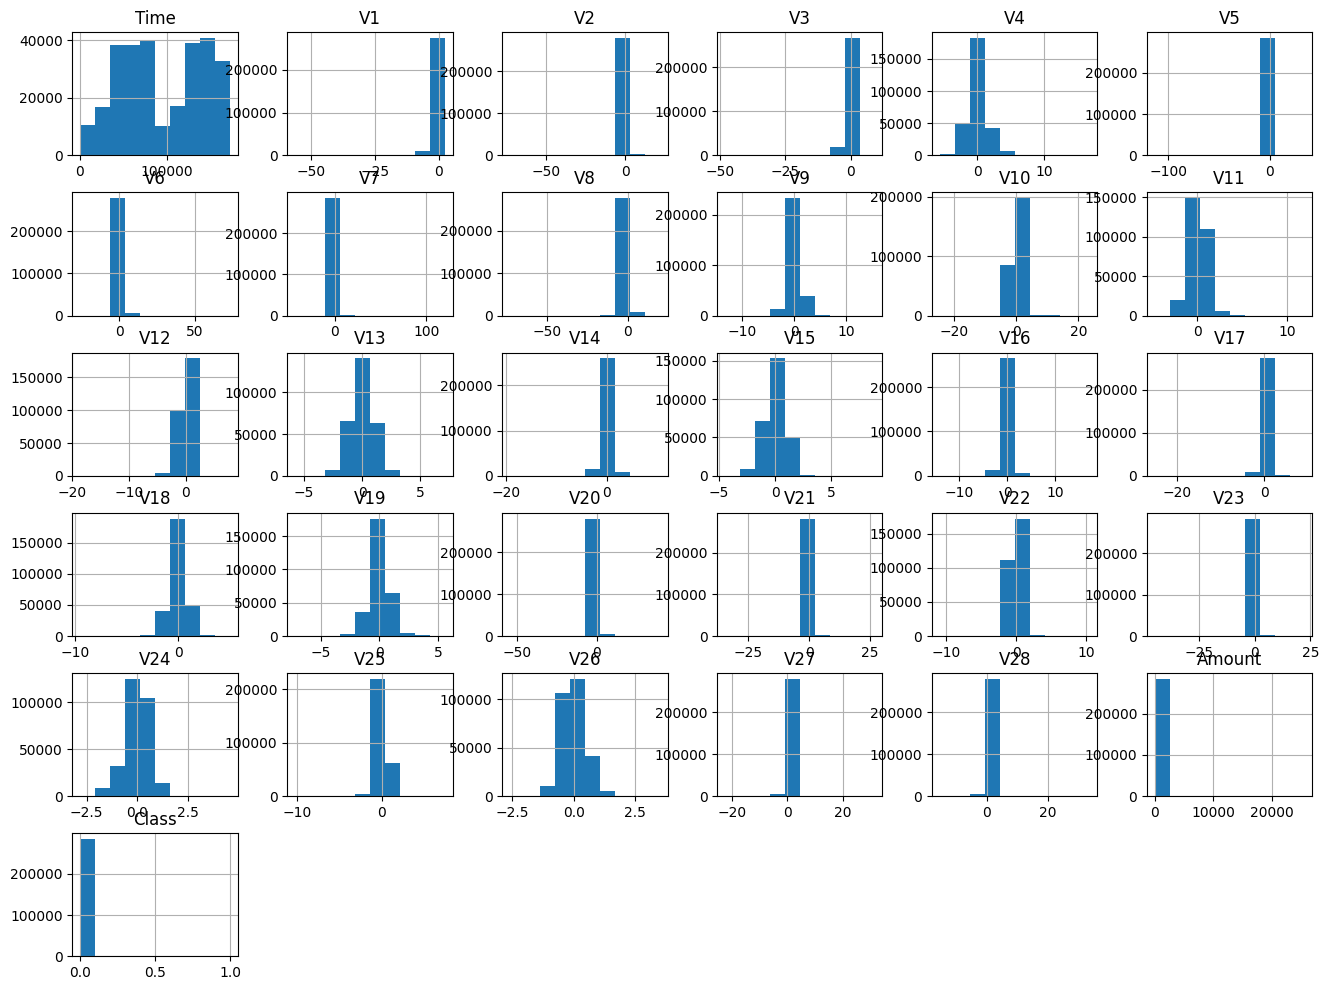

In [6]:
raw_df.hist(figsize=(16,12))
plt.show()

In [7]:
# numeric_columns = (list(raw_df.loc[:, ['Time','Amount']]))

# fig = plt.figure(figsize=(20, 50))
# rows, cols = 10, 3
# for idx, num in enumerate(numeric_columns[:30]):
#     ax = fig.add_subplot(rows, cols, idx+1)
#     ax.grid(alpha = 0.7, axis ="both")
#     sns.kdeplot(x = num, fill = True,color ="#3386FF",linewidth=0.6, data = raw_df)
#     ax.legend()
# fig.tight_layout()
# fig.show()

### Genuine vs Fraud Comparation

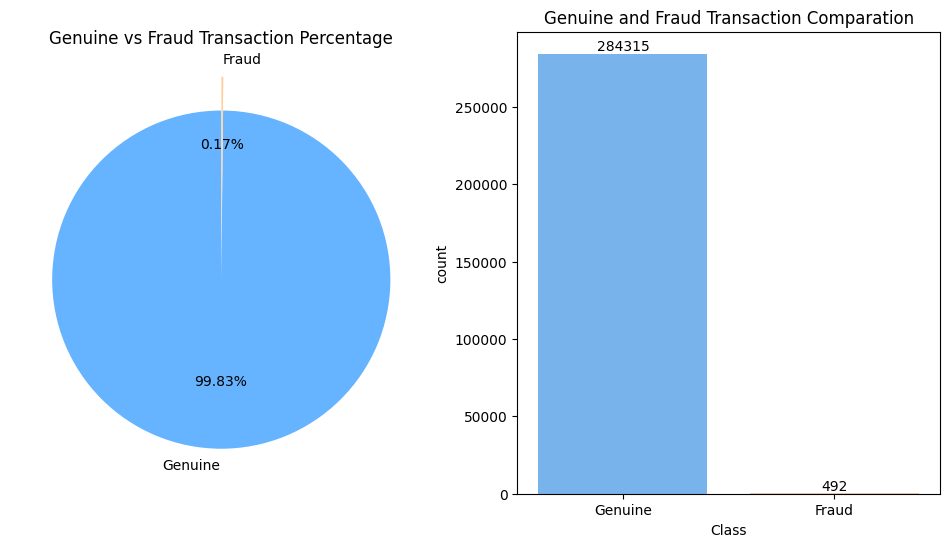

In [8]:
tmp = raw_df.Class.value_counts()
pie_val = [tmp[0] / sum(tmp) * 100, tmp[1] / sum(tmp) * 100]
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(pie_val,labels = ['Genuine','Fraud'], 
        autopct = '%1.2f%%',
        startangle = 90,
        explode = (0.1,0.1),
        colors = ['#66b3ff','#ffcc99'], 
        wedgeprops = {'linewidth': 1, 'antialiased' : True})
plt.title('Genuine vs Fraud Transaction Percentage')

plt.subplot(1,2,2)
ax = sns.countplot(data = raw_df, 
                   x='Class', 
                   palette = ['#66b3ff','#ffcc99']
                   )
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Genuine','Fraud'])
    
plt.title('Genuine and Fraud Transaction Comparation')
plt.show()

Text(0.5, 1.0, 'Genuine vs Fraud Time Mean')

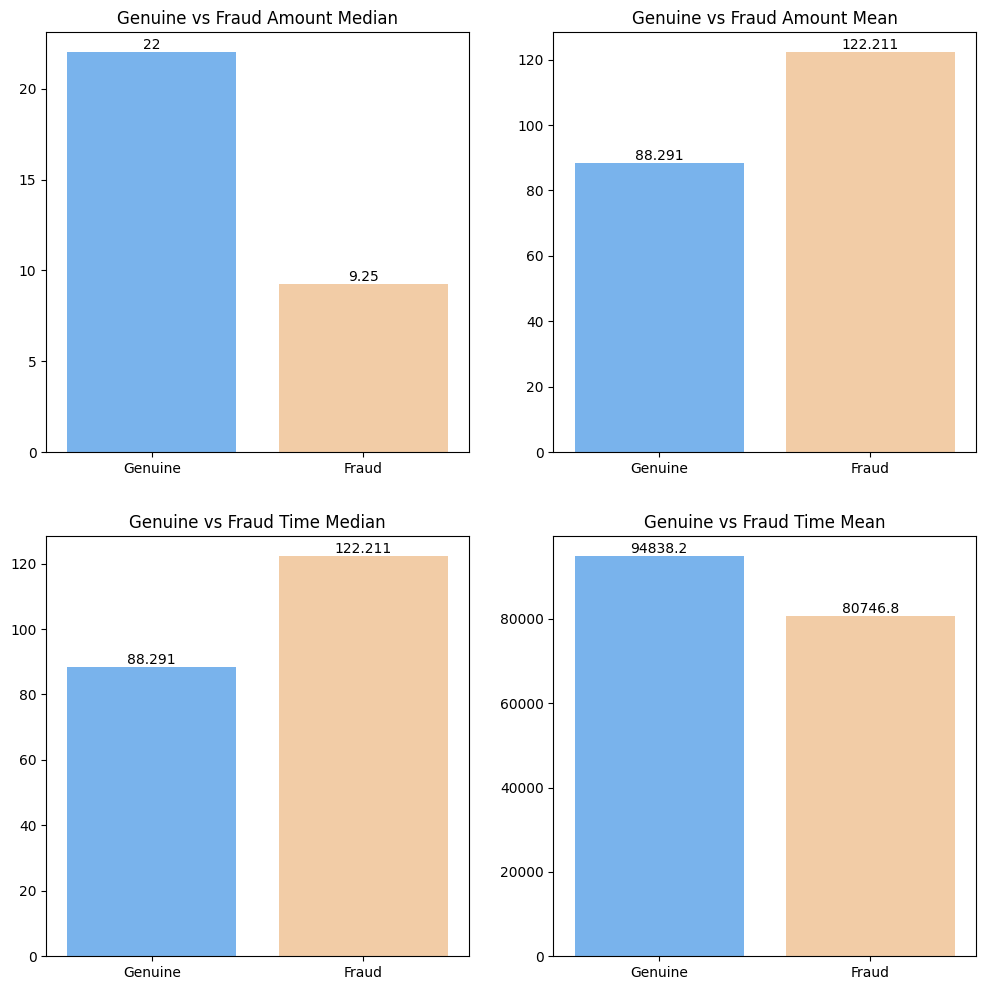

In [9]:
plt.figure(figsize=(12,12))

tmp = {}
for i, data in enumerate(raw_df.groupby('Class')['Amount'].median()):
    tmp[i] = data

plt.subplot(2,2,1)
ax = sns.barplot(x=list(tmp.keys()),
                 y=[float(tmp[k]) for k in tmp.keys()],
                 palette=['#66b3ff','#ffcc99'])
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Genuine','Fraud'])
ax.set_title('Genuine vs Fraud Amount Median')

tmp = {}
for i, data in enumerate(raw_df.groupby('Class')['Amount'].mean()):
    tmp[i] = data

plt.subplot(2,2,2)
ax = sns.barplot(x=list(tmp.keys()),
                 y=[float(tmp[k]) for k in tmp.keys()],
                 palette=['#66b3ff','#ffcc99'])
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Genuine','Fraud'])
ax.set_title('Genuine vs Fraud Amount Mean')

plt.subplot(2,2,3)
ax = sns.barplot(x=list(tmp.keys()),
                 y=[float(tmp[k]) for k in tmp.keys()],
                 palette=['#66b3ff','#ffcc99'])
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Genuine','Fraud'])
ax.set_title('Genuine vs Fraud Time Median')

tmp = {}
for i, data in enumerate(raw_df.groupby('Class')['Time'].mean()):
    tmp[i] = data

plt.subplot(2,2,4)
ax = sns.barplot(x=list(tmp.keys()),
                 y=[float(tmp[k]) for k in tmp.keys()],
                 palette=['#66b3ff','#ffcc99'])
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Genuine','Fraud'])
ax.set_title('Genuine vs Fraud Time Mean')

Both Amount and Time have very significant mean and median differences due to influence of outliers

### Feature Correlation

<AxesSubplot: >

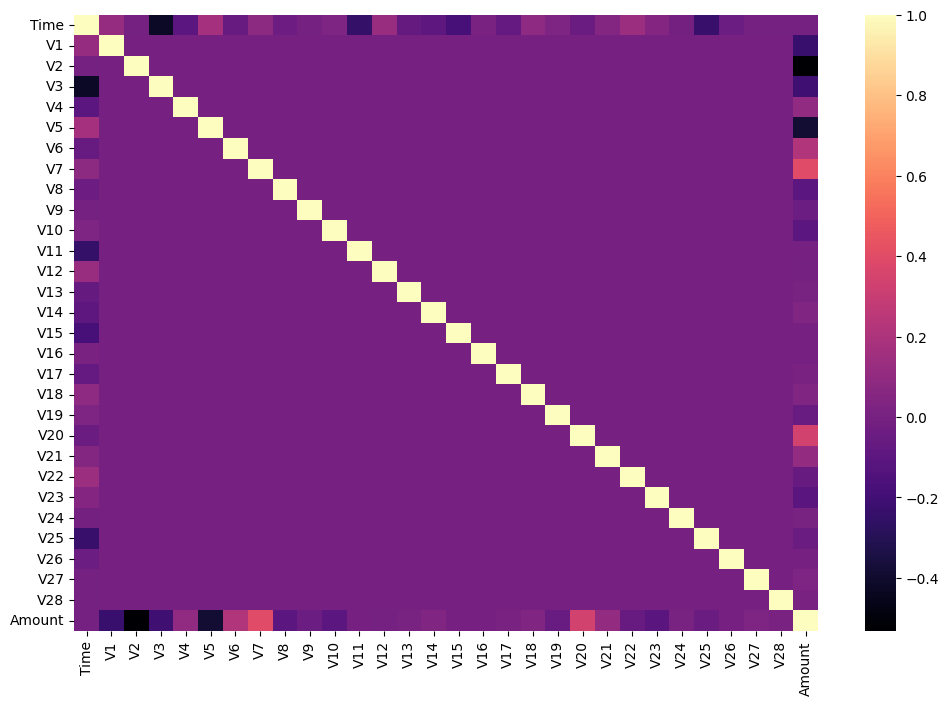

In [10]:
plt.figure(figsize=(12,8))
sns.heatmap(raw_df.drop('Class', axis=1).corr(), cmap='magma')

Amount and Time have a weak to moderate correlation with some of the features in the data set.

### Checking Outlier Data

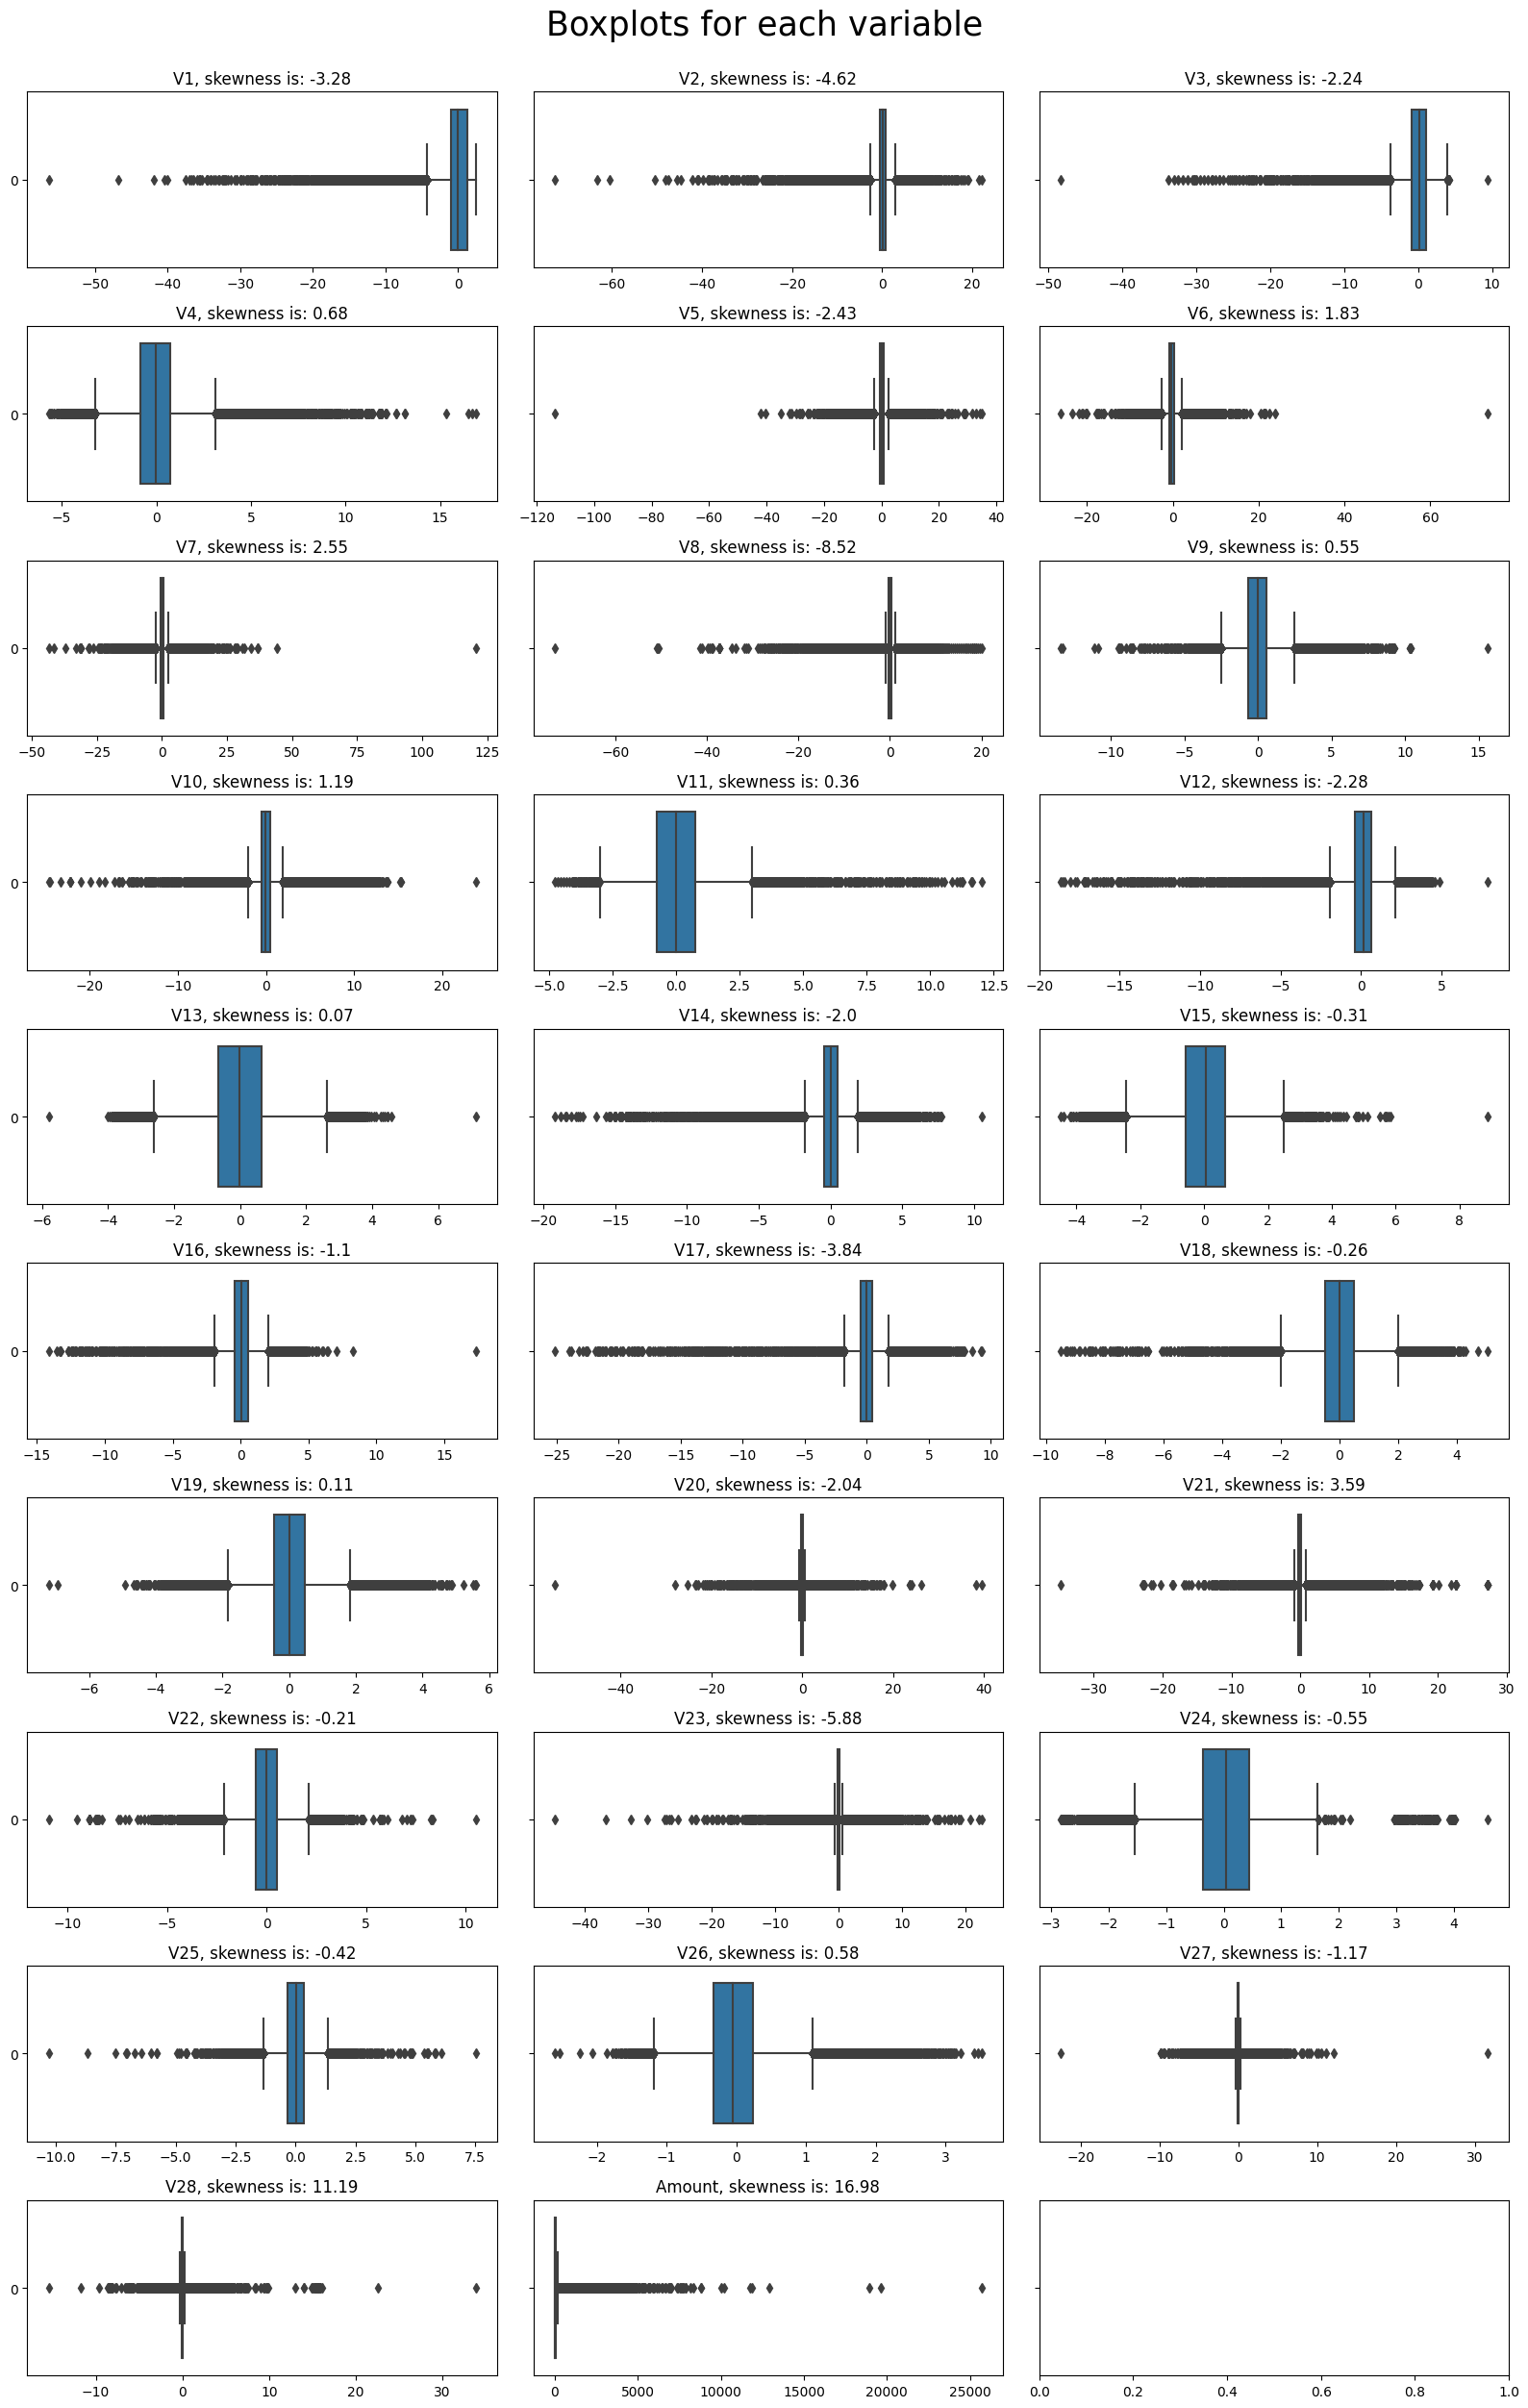

In [11]:
# select only numeric features
numeric_features = (list(raw_df.loc[:, 'V1':'Amount'])) 

# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=raw_df, columns_list=numeric_features, rows=10, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

there is a lot of outlier from each features, now try to remove it using Inter Quartile Range (IQR) method 

#### Removing Outlier with IQR

In [12]:
import numpy as np
from collections import Counter

In [13]:
def IQR_method (df,min_outliers,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > min_outliers )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [14]:
numeric_columns = (list(raw_df.loc[:, 'Time':'Amount']))

iqr_outliers = IQR_method(raw_df,1,numeric_columns)
raw_df2 = raw_df.drop(iqr_outliers, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 31904


In [15]:
raw_df2.Class.value_counts()

0    203351
1        26
Name: Class, dtype: int64

too much missing value, revert to non-removing outlier data

In [16]:
del raw_df2

## Preprocessing Data

### Drop Unused Feature

In [17]:
# raw_df.drop('Time',axis=1, inplace=True)

### Split Data

In [18]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [28]:
X = raw_df.drop('Class', axis=1)
y = raw_df['Class']

X_train_cv = []
X_test_cv = []
y_train_cv = []
y_test_cv = []
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train_cv.append(X.loc[train_index,:])
    X_test_cv.append(X.loc[test_index,:])
    y_train_cv.append(y.loc[train_index])
    y_test_cv.append(y.loc[test_index])



In [29]:
print(y_train_cv[0].value_counts())
print(y_test_cv[0].value_counts())

0    227452
1       393
Name: Class, dtype: int64
0    56863
1       99
Name: Class, dtype: int64


In [30]:
from sklearn.preprocessing import StandardScaler

### Scale Data

In [31]:
scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index=X_train.index)
# X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns, index=X_test.index)

# raw_df[["Amount"]] = scaler.fit_transform(raw_df[["Amount"]])
# raw_df[["Time"]] = scaler.fit_transform(raw_df[["Time"]])

# Transforming the test data
# X_test[["Amount"]] = scaler.transform(X_test[["Amount"]])
# X_test[["Time"]] = scaler.transform(X_test[["Time"]])

for i in range(len(X_train_cv)):
    X_train_cv[i][["Amount","Time"]] = scaler.fit_transform(X_train_cv[i][["Amount","Time"]])
#     X_train_cv[i][["Time"]] = scaler.fit_transform(X_train_cv[i][["Time"]])

    # Transforming the test data
#     X_test_cv[i][["Amount"]] = scaler.transform(X_test_cv[i][["Amount"]])
    X_test_cv[i][["Amount","Time"]] = scaler.transform(X_test_cv[i][["Amount","Time"]])

## Model Training

In [32]:
import time
import numpy
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, auc, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [33]:
model_result = []

### Logistic Regression

In [34]:
# %%time
# logr = LogisticRegression(random_state=1)
# logr.fit(X_train, y_train)
# y_preds = logr.predict(X_test)
# print(classification_report(y_test,y_preds))
# y_probs = logr.predict_proba(X_test)
# # keep probabilities for the positive outcome only
# y_probs = y_probs[:, 1]
# # predict class values
# yhat = logr.predict(X_test)
# lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_probs)
# lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# # summarize scores
# print(f'Logistic: f1 = {round(lr_f1,3)} auc = {round(lr_auc,3)}')
# # plot the precision-recall curves
# # no_skill = len(y_test[y_test==1]) / len(y_test)
# # plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# plt.plot(lr_recall, lr_precision, label='Logistic')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.legend()
# plt.show()


fold #1
training time 2.919121503829956
f1 score: 0.7231638418079097
fold #2
training time 2.7727344036102295
f1 score: 0.7228915662650603
fold #3
training time 2.5926265716552734
f1 score: 0.7218934911242604
fold #4
training time 3.640876293182373
f1 score: 0.7239263803680982
fold #5
training time 3.120054006576538
f1 score: 0.7529411764705882

Avg. Training time: 3.044126343727112
Avg. F1-Score Positive class: 0.7289632912071834


Text(0.5, 1.0, 'Precision-Recall Curve for Positive Class')

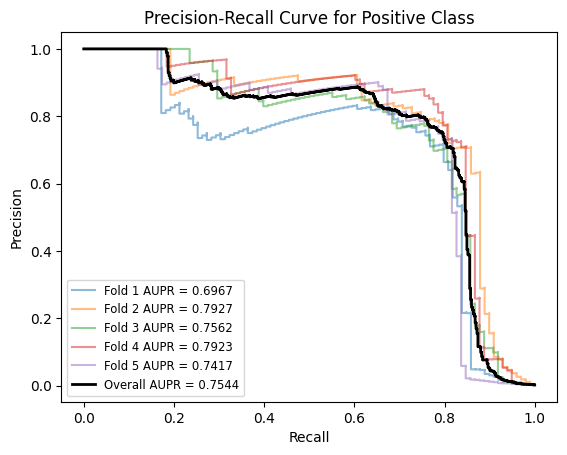

In [35]:
logr = LogisticRegression(random_state=1)

axes = plt.subplot()
y_real = []
y_proba = []
f1_list = []
# auc_list = []
time_list = []
for i in range(len(X_train_cv)):
    print(f'fold #{i+1}')
    start_time = time.time()
    logr.fit(X_train_cv[i],y_train_cv[i])
    elapsed_time = time.time() - start_time
    print(f'training time {elapsed_time}')
    time_list.append(elapsed_time)
    y_probs = logr.predict_proba(X_test_cv[i])
    # probabilities for the positive outcome only
    y_probs = y_probs[:, 1]
    # predict class values
    yhat = logr.predict(X_test_cv[i])
    f_score = f1_score(y_test_cv[i], yhat)
    f1_list.append(f_score)
    print('f1 score:',f_score)
    time_list.append(time.time() - start_time)
    # print(classification_report(y_test_cv[i],yhat))
    res_precision, res_recall, _ = precision_recall_curve(y_test_cv[i], y_probs)
    aupr = average_precision_score(y_test_cv[i], y_probs)
    lab = 'Fold %d AUPR = %.4f' % (i+1, aupr)
#     model_result.append({'model':'Logistic Regression', 'rec': res_recall, 'prec':res_precision, 'aupr':aupr})
    axes.step(res_recall, res_precision, label=lab, alpha=0.5)
    # y_real.append(y_test_cv[i])
    y_proba.append(y_probs)

print()
print('Avg. Training time:',sum(time_list)/len(time_list))
print('Avg. F1-Score Positive class:',sum(f1_list)/len(f1_list))

y_real = numpy.concatenate(y_test_cv)
y_proba = numpy.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUPR = %.4f' % (average_precision_score(y_real, y_proba))
axes.step(recall, precision, label=lab, lw=2, color='black')
axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='lower left', fontsize='small')
axes.set_title('Precision-Recall Curve for Positive Class')

### Random Forest

In [36]:
# rfc = RandomForestClassifier(random_state=1)
# rfc.fit(X_train, y_train)
# y_preds = rfc.predict(X_test)
# print(classification_report(y_test,y_preds))
# y_probs = rfc.predict_proba(X_test)
# # keep probabilities for the positive outcome only
# y_probs = y_probs[:, 1]
# # predict class values
# yhat = rfc.predict(X_test)
# lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_probs)
# lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# # summarize scores
# print(f'Logistic: f1 = {round(lr_f1,3)} auc = {round(lr_auc,3)}')
# # plot the precision-recall curves
# # no_skill = len(y_test[y_test==1]) / len(y_test)
# # plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# plt.plot(lr_recall, lr_precision, label='Logistic')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.legend()
# plt.show()

fold #1
training time 289.3471665382385
f1 score: 0.8397790055248618
fold #2
training time 294.5164039134979
f1 score: 0.8791208791208791
fold #3
training time 296.5020864009857
f1 score: 0.839080459770115
fold #4
training time 287.5557723045349
f1 score: 0.871508379888268
fold #5
training time 274.74527955055237
f1 score: 0.8651685393258427

Avg. Training time: 289.19784133434297
Avg. F1-Score Positive class: 0.8589314527259934


Text(0.5, 1.0, 'Precision-Recall Curve for Positive Class')

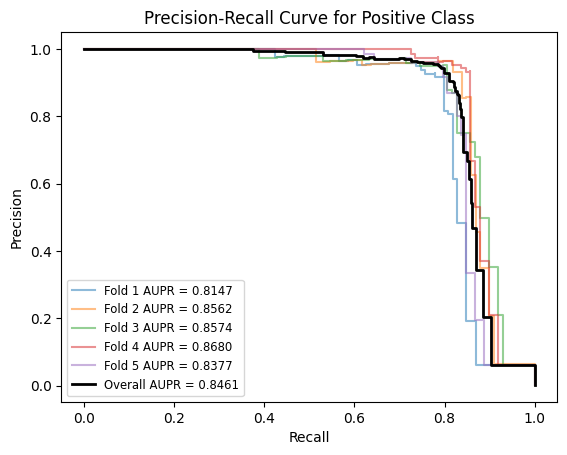

In [38]:
rfc = RandomForestClassifier(n_estimators=100,random_state=1)

axes = plt.subplot()
y_real = []
y_proba = []
f1_list = []
# auc_list = []
time_list = []
for i in range(len(X_train_cv)):
    print(f'fold #{i+1}')
    start_time = time.time()
    rfc.fit(X_train_cv[i],y_train_cv[i])
    elapsed_time = time.time() - start_time
    print(f'training time {elapsed_time}')
    time_list.append(elapsed_time)
    y_probs = rfc.predict_proba(X_test_cv[i])
    # probabilities for the positive outcome only
    y_probs = y_probs[:, 1]
    # predict class values
    yhat = rfc.predict(X_test_cv[i])
    f_score = f1_score(y_test_cv[i], yhat)
    f1_list.append(f_score)
    print('f1 score:',f_score)
    time_list.append(time.time() - start_time)
    # print(classification_report(y_test_cv[i],yhat))
    res_precision, res_recall, _ = precision_recall_curve(y_test_cv[i], y_probs)
    aupr = average_precision_score(y_test_cv[i], y_probs)
    lab = 'Fold %d AUPR = %.4f' % (i+1, aupr)
#     model_result.append({'model':'Random Forest', 'rec': res_recall, 'prec':res_precision, 'aupr':aupr})
    axes.step(res_recall, res_precision, label=lab, alpha=0.5)
    # y_real.append(y_test_cv[i])
    y_proba.append(y_probs)

print()
print('Avg. Training time:',sum(time_list)/len(time_list))
print('Avg. F1-Score Positive class:',sum(f1_list)/len(f1_list))

y_real = numpy.concatenate(y_test_cv)
y_proba = numpy.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUPR = %.4f' % (average_precision_score(y_real, y_proba))
axes.step(recall, precision, label=lab, lw=2, color='black')
axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='lower left', fontsize='small')
axes.set_title('Precision-Recall Curve for Positive Class')

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=9)
# knn.fit(X_train, y_train)

In [ ]:
# y_preds = knn.predict(X_test)
# print(classification_report(y_test,y_preds))

In [ ]:
# y_probs = knn.predict_proba(X_test)
# # keep probabilities for the positive outcome only
# y_probs = y_probs[:, 1]
# # predict class values
# yhat = knn.predict(X_test)
# lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_probs)
# lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# # summarize scores
# print(f'Logistic: f1 score positive class = {round(lr_f1,3)} auc = {round(lr_auc,3)}')
# # plot the precision-recall curves
# # no_skill = len(y_test[y_test==1]) / len(y_test)
# # plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# plt.plot(lr_recall, lr_precision, label='RFC')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.legend()
# plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9)

axes = plt.subplot()
y_real = []
y_proba = []
f1_list = []
# auc_list = []
time_list = []
for i in range(len(X_train_cv)):
    print(f'fold #{i+1}')
    start_time = time.time()
    knn.fit(X_train_cv[i],y_train_cv[i])
    elapsed_time = time.time() - start_time
    print(f'training time {elapsed_time}')
    time_list.append(elapsed_time)
    y_probs = knn.predict_proba(X_test_cv[i])
    # probabilities for the positive outcome only
    y_probs = y_probs[:, 1]
    # predict class values
    yhat = knn.predict(X_test_cv[i])
    f_score = f1_score(y_test_cv[i], yhat)
    f1_list.append(f_score)
    print('f1 score:',f_score)
    time_list.append(time.time() - start_time)
    # print(classification_report(y_test_cv[i],yhat))
    res_precision, res_recall, _ = precision_recall_curve(y_test_cv[i], y_probs)
    aupr = average_precision_score(y_test_cv[i], y_probs)
    lab = 'Fold %d AUPR = %.4f' % (i+1, aupr)
    model_result.append({'model':'Logistic Regression', 'rec': res_recall, 'prec':res_precision, 'aupr':aupr})
    axes.step(res_recall, res_precision, label=lab, alpha=0.5)
    # y_real.append(y_test_cv[i])
    y_proba.append(y_probs)

print()
print('Avg. Training time:',sum(time_list)/len(time_list))
print('Avg. F1-Score Positive class:',sum(f1_list)/len(f1_list))

y_real = numpy.concatenate(y_test_cv)
y_proba = numpy.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUPR = %.4f' % (average_precision_score(y_real, y_proba))
axes.step(recall, precision, label=lab, lw=2, color='black')
axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='lower left', fontsize='small')
axes.set_title('Precision-Recall Curve for Positive Class')